In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
import numpy as np

import camb
from camb import model, initialpower
import pandas as pd

In [2]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location(
    "spectra", "../shared/spectra.py")
spectra = importlib.util.module_from_spec(spec)
sys.modules["spectra"] = spectra
spec.loader.exec_module(spectra)

In [3]:
omega_index = 1 # while we debug, we confine our attention to just one value
onh2 = spectra.omegas_nu[omega_index]
onh2_str = spectra.omnu_strings[omega_index]

In [4]:
'''
First, we need to define a Pandas table containing my exotic cosmologies.
'''
num_models = 10
def row_conglomerator():
    rows = [spectra.get_cosmology() for i in range(num_models)]
    conglomerate = {}
    for key in rows[0].keys():
        conglomerate[key] = [rows[0][key]]
        for i in range(1, num_models):
            conglomerate[key].append(rows[i][key])
    return conglomerate
            
conglomerate = row_conglomerator()
cosm = pd.DataFrame.from_dict(conglomerate)
cosm

,OmM,OmL,OmK,OmC,OmB,h,w0,wa,omch2,ombh2,n_s,A_s
0,0.097669,0.724067,0.178263,0.091346,0.908654,0.729126,-1.017738,0.154224,0.048562,0.483063,0.683516,1.924844e-09
1,0.531621,0.023814,0.444565,0.191933,0.808067,0.655877,-1.007543,-0.033352,0.082565,0.347610,0.515452,2.469296e-09
2,0.810868,0.115744,0.073387,0.785148,0.214852,0.626696,-0.972609,0.089577,0.308365,0.084383,0.705276,2.157855e-09
3,0.927971,0.018623,0.053407,0.575688,0.424312,0.575454,-1.048025,-0.058374,0.190637,0.140510,0.468909,2.175320e-09
4,0.020688,0.626253,0.353059,0.014594,0.985406,0.574630,-1.012681,0.058736,0.004819,0.325381,0.761196,2.055377e-09
5,0.962163,0.004674,0.033163,0.859157,0.140843,0.733166,-0.941830,-0.161507,0.461825,0.075708,0.947919,2.292225e-09
6,0.031673,0.307674,0.660654,0.011915,0.988085,0.788996,-1.142850,-0.164400,0.007418,0.615098,0.848800,2.447692e-09
7,0.384477,0.426802,0.188721,0.380469,0.619531,0.562377,-0.918204,-0.192573,0.120330,0.195938,0.615756,2.020772e-09
8,0.046130,0.930230,0.023640,0.044351,0.955649,0.744795,-0.922838,-0.186608,0.024602,0.530117,0.312603,2.433738e-09
9,0.723159,0.077461,0.199380,0.273052,0.726948,0.702084,-0.907017,0.183804,0.134593,0.358328,0.746704,2.120121e-09


In [5]:
# It's a waste of time to consider all of the omegas and snapshots, so we're
# making heavy use of skips.
spec_sims = spectra.better_battery(spectra.omegas_nu, spectra.omnu_strings,
    skips_omega = [0, 2, 3], skips_model=[], skips_snapshot=[1, 2, 3],
    models=cosm)

0
1
2


"\nWhy didn't model 0 take anywhere near as long as model 1 to process? They're\nboth supposed to have been randomized. And anyway we encountered a bug with\nmodel 1 that we didn't with model 0--this suggests that my code is, in a hard-\ncoded way, handling model 0 differently from the rest. Fix ASAP!\n"

KeyError: 9

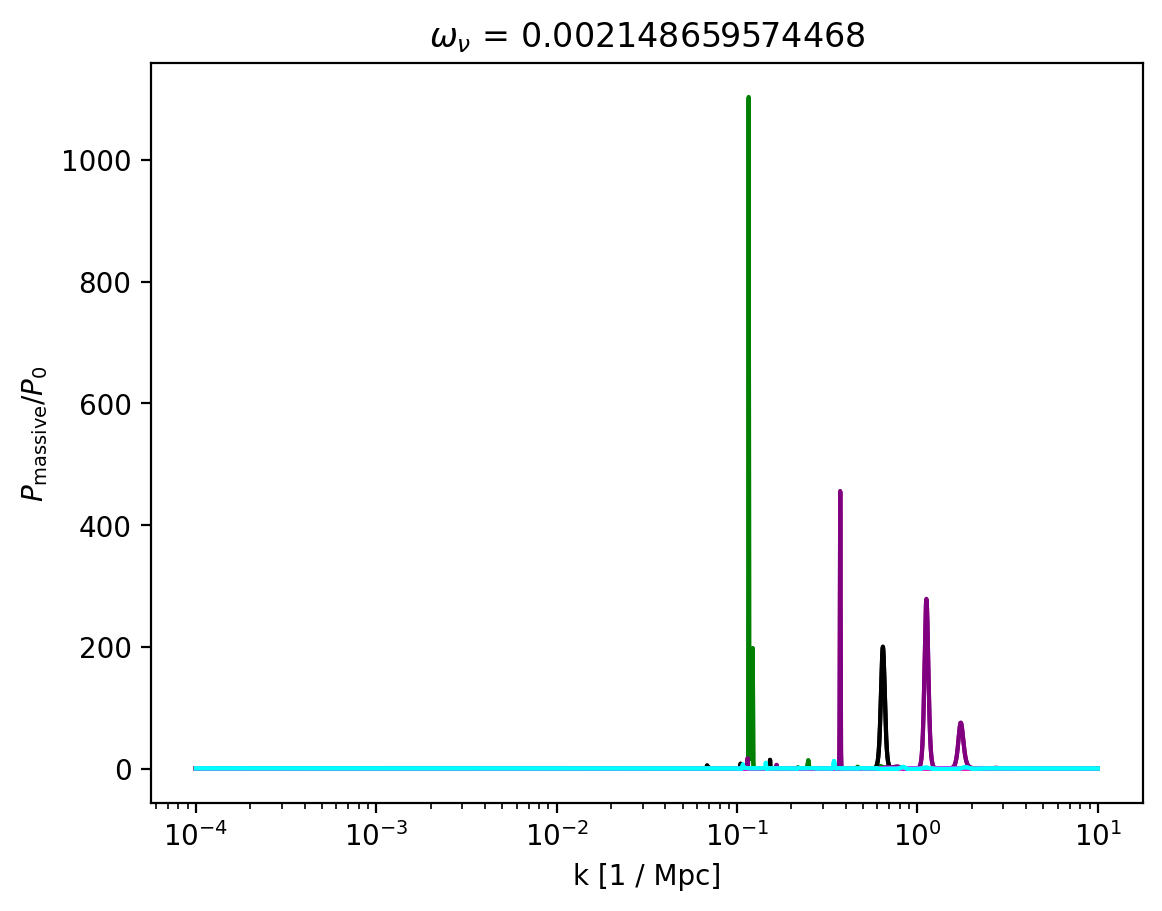

In [6]:
for i in range(len(spec_sims[onh2_str])):
    if spec_sims[onh2_str][i] is None:
        continue
    h = spectra.cosm.loc[i]["h"]
    for j in range(len(spec_sims[onh2_str][i])):
        if spec_sims[onh2_str][i][j] is None:
            continue
        plt.plot(spec_sims[onh2_str][i][j]["k"],
            spec_sims[onh2_str][i][j]["P_nu"] / \
            spec_sims[onh2_str][i][j]["P_no"],
            label="model " + str(i) + ", no renormalizing, z=" + \
            str(spectra.parse_redshifts(i)[j]), c=spectra.colors[i],
            linestyle=spectra.styles[i])
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    plt.title(r"$\omega_\nu$ = " + str(onh2))

In [ ]:
for i in range(0, 3):
    if spec_sims[onh2_str][i] is None:
        continue
    h = spectra.cosm.loc[i]["h"]
    j = 4 # just look at z=0 before moving on
    plt.plot(spec_sims[onh2_str][i][j]["k"],
        spec_sims[onh2_str][i][j]["P_nu"] / \
        spec_sims[onh2_str][i][j]["P_no"],
        label="model " + str(i), c=spectra.colors[i])
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    plt.title(r"$\omega_\nu$ = " + str(onh2) + "; $z=0$?")

Currently I am not re-normalizing the amplitude of one model based on its counterpart. At least, I *think* I'm not doing that, but I'm really quite unsure

In [ ]:
true2_early = spectra.powernu2[0][0]
true2_late = spectra.powernu2[0][4]
true_early = spectra.powernu[onh2_str][0][0]
true_late = spectra.powernu[onh2_str][0][4]

In [ ]:
i = 0
h = spectra.cosm.loc[i]["h"]
j = 4 # this should be SNAP index, not z index
z_list = spectra.parse_redshifts(i)
print(z_list)
sim = spec_sims[onh2_str][i][j]

plt.plot(sim["k"], sim["P_nu"] / sim["P_no"], c=spectra.colors[i],
    label="my result for z=" + str(sim["z"]))
plt.plot(true_late["k"], true_late["ratio"], label="powernu.tar snapshot 4")
plt.plot(true2_late["k"], true2_late["ratio"],
    label="powernu2.tar snapshot 4")

j = 0 # This will correspond to z=0 for the model0 case.
sim = spec_sims[onh2_str][i][j]

plt.plot(sim["k"], sim["P_nu"] / sim["P_no"], c="black",
    label="my result for z=" + str(sim["z"]))
plt.plot(true_early["k"], true_early["ratio"], label="powernu.tar snapshot 0")
plt.plot(true2_early["k"], true2_early["ratio"],
    label="powernu.tar2 snapshot 0")

plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P_\mathrm{massive} / P_0$")
plt.title(r"$\omega_\nu$ = " + onh2_str + "; model 0")
plt.legend()

# This protects other cells by avoiding unintended reuse
del i, h, j, z_list, sim

We've now made absolutely certain that my lines here should overlap with Ariel's. What went wrong?

In [ ]:
print(spec_sims[onh2_str][0][4]["z"])
print(spec_sims[onh2_str][0][0]["z"])

In [ ]:
i = 0
h = spectra.cosm.loc[i]["h"]
j = 4
sim = spec_sims[onh2_str][i][j]

plt.plot(sim["k"], sim["P_no"], label="my no-neut", c=spectra.colors[i])
plt.plot(sim["k"], sim["P_nu"], label="my neuts", c="black")
plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P(k)$ [?]")
plt.title(r"$\omega_\nu$ = " + str(onh2) + "; model 0")
plt.legend()

# This protects other cells by avoiding accidental reuse
del i, h, j, sim

In [ ]:
true3_early = spectra.powernu3[onh2_str][0][0]
true3_late = spectra.powernu3[onh2_str][0][4]

LCDM = np.load('../../CAKE21/matteos_spectra/LCDM.npy', allow_pickle=True)
nuCDM = np.load('../../CAKE21/matteos_spectra/nuCDM.npy', allow_pickle=True)

In [ ]:
i = 0
h = spectra.cosm.loc[i]["h"]
j = 4 # this should be SNAP index, not z index
z_list = spectra.parse_redshifts(i)
sim = spec_sims[onh2_str][i][j]

plt.plot(sim["k"], sim["P_nu"] / sim["P_no"], c=spectra.colors[i],
    label="my result for z=" + str(sim["z"]))
plt.plot(true3_late["k"], true3_late["ratio"],
         label="powernu3.tar snapshot 4")
plt.plot(LCDM[0]['kk'], nuCDM[0]['Pk'][4]/LCDM[0]['Pk'][4],
             label='Matteo, snapshot 4?'.format(0))

j = 0 # This will correspond to z=0 for the model0 case.
sim = spec_sims[onh2_str][i][j]

plt.plot(sim["k"], sim["P_nu"] / sim["P_no"], c="black",
    label="my result for z=" + str(sim["z"]))
plt.plot(true3_early["k"], true3_early["ratio"],
         label="powernu3.tar snapshot 0")
plt.plot(LCDM[0]['kk'], nuCDM[0]['Pk'][0]/LCDM[0]['Pk'][0],
             label='Matteo, snapshot 0?'.format(0))

plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P_\mathrm{massive} / P_0$")
plt.title(r"$\omega_\nu$ = " + onh2_str + "; model 0")
plt.legend()

# This protects other cells by avoiding unintended reuse
del i, h, j, z_list, sim